In [1]:
%matplotlib inline

from __future__ import print_function

import math
import cmath
import re
import os
import glob
from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import log_loss, accuracy_score
import tensorflow as tf
from tensorflow.python.data import Dataset
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

# DEBUGGING AND OUTPUT
PLOT = True
SUMMARIZE = True

# NOTES
NOTES = ""

# Vars
AGES = None
target_label = "Survived"
id_label = "PassengerId"
CORR_THRESH = 0.3
TITLES = []
TYPE = "DNN"
OUTSTR = "A{:.2f}_C{:.2f}_Type{}_F{}{}.csv"
USELESS = ["Ticket", "Cabin", "Name", 'Parch', 'SibSp']
FEATURES = ["Age", "Pclass", "Sex", "HasCabin", "Fare", "NumFamily", "Embarked", "Title"]

# PATHS
paths = {
    "Training":"/home/wesleytocs/.kaggle/competitions/titanic/train.csv",
    "Testing":"/home/wesleytocs/.kaggle/competitions/titanic/test.csv",
    "Submission":"/home/wesleytocs/.kaggle/competitions/titanic/gender_submission.csv",
}

def summarize(dataframe, depth=5):
    if SUMMARIZE:
        print(dataframe.info())
        display.display(dataframe.describe())

def find_na(df):
    l = []
    for label in df.columns:
        if df[label].dropna().shape[0] != df.shape[0]:
            l.append(label)
    return l

def numerical_labels(df):
    l = []
    for label in df.columns:
        if df[label].dtype in ["int32", "float32", "float64", "int64"]:
            l.append(label)
    return l

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""

def get_age_from_title(title, dataframe):
    age = dataframe["Age"].mean()
    df = dataframe[dataframe["Title"] == title]
    age = df["Age"].mean()
    return age

def embarked_feature_columns():
    embarked_feature_columns = tf.feature_column.categorical_column_with_vocabulary_list( 
        key='Embarked',
        vocabulary_list = ('C','Q','S') )
    return tf.feature_column.indicator_column(embarked_feature_columns)

def sex_feature_columns():
    sex_feature_columns = tf.feature_column.categorical_column_with_vocabulary_list( 
        key='Sex',
        vocabulary_list = ['male','female'] )
    return tf.feature_column.indicator_column(sex_feature_columns)

def pclass_feature_columns():
    pclass_feature_columns = tf.feature_column.categorical_column_with_identity(
        key='Pclass',
        num_buckets = 4)
    return tf.feature_column.indicator_column(pclass_feature_columns)

def title_feature_columns():
    title_feature_columns = tf.feature_column.categorical_column_with_hash_bucket(
         key = 'Title',
         hash_bucket_size = len(TITLES))
    return tf.feature_column.indicator_column(title_feature_columns)

def age_feature_column():
    a = tf.feature_column.numeric_column("Age")
    age_feature_column = tf.feature_column.bucketized_column(
        source_column=a,
        boundaries=[3, 10, 17, 27, 40]
    )
    return tf.feature_column.indicator_column(age_feature_column)

def fare_feature_column():
    f = tf.feature_column.numeric_column("Fare")
    fare_feature_column = tf.feature_column.bucketized_column(
        source_column=f,
        boundaries=[25, 50, 100, 175, 350]
    )
    return tf.feature_column.indicator_column(fare_feature_column)

def num_family_feature_column():
    return tf.feature_column.numeric_column(key='NumFamily')

def has_cabin_feature_column():
    return tf.feature_column.numeric_column(key='HasCabin')

def construct_feature_columns():
    return [
        f() for f in [
            pclass_feature_columns,
            sex_feature_columns,
            age_feature_column,
            num_family_feature_column,
            has_cabin_feature_column,
            fare_feature_column,
            embarked_feature_columns
        ]
    ]

def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

def train_nn_classification_model(
    learning_rate,
    steps,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    l1=False,
    l2=False,
    l1_strength=0.00001,
    l2_strength=0.00001):

    periods = max(10, steps // 10000)

    steps_per_period = steps / periods  
    # Create the input functions.
    training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets[target_label], 
        batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(
        training_examples, 
        training_targets[target_label], 
        num_epochs=1, 
        shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(
        validation_examples, 
        validation_targets[target_label], 
        num_epochs=1, 
        shuffle=False)

    # Create a DNNClassifier object.
    if l1:
        if l2:
            my_optimizer=tf.train.ProximalAdagradOptimizer(
                learning_rate=learning_rate,
                l1_regularization_strength=l1_strength, 
                l2_regularization_strength=l2_strength
            )
        else:
            my_optimizer=tf.train.ProximalAdagradOptimizer(
                learning_rate=learning_rate,
                l1_regularization_strength=l1_strength
            )
    elif l2:
        my_optimizer=tf.train.ProximalAdagradOptimizer(
            learning_rate=learning_rate,
            l2_regularization_strength=l2_strength
        )
    else:
        my_optimizer=tf.train.ProximalAdagradOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    classifier = tf.estimator.DNNClassifier(
        feature_columns=construct_feature_columns(),
        n_classes=2,
        hidden_units = hidden_units,
        optimizer=my_optimizer,
        config=tf.estimator.RunConfig(keep_checkpoint_max=1)
    )

    t_acc = []
    v_acc = []

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...\n\tAccuracy:")
    for period in range (0, periods):
        # Train the model, starting from the prior state.
        classifier.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        training_predictions = classifier.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['class_ids'][0] for item in training_predictions])

        validation_predictions = classifier.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['class_ids'][0] for item in validation_predictions])

        t_accuracy = accuracy_score(training_targets, training_predictions)
        v_accuracy = accuracy_score(validation_targets, validation_predictions)
        t_acc.append(t_accuracy)
        v_acc.append(v_accuracy)
        print("\t\tPeriod: {}\tTest: {:.2f}\tValidation: {:.2f}".format(period, t_accuracy, v_accuracy))
    print("Model training finished.")

    # Output a graph of loss metrics over periods.
    plt.ylabel("Accuracy")
    plt.xlabel("Periods")
    plt.title("Accuracy vs. Periods")
    plt.tight_layout()
    plt.plot(t_acc, label="training")
    plt.plot(v_acc, label="validation")
    plt.legend()
    plt.show()

    # Calculate final predictions (not probabilities, as above).
    final_predictions = classifier.predict(input_fn=predict_validation_input_fn)
    final_predictions = np.array([item['class_ids'][0] for item in final_predictions])

    accuracy = accuracy_score(validation_targets, final_predictions)
    print("Final accuracy (on validation data): %0.2f" % accuracy)

    return (classifier, accuracy)

def preprocess_all_data(dataframe, merge=True):
    """Prepares all the data columns to be in usable formats
        (Normalizes, encodes, etc...)
    """
    global TITLES, AGES
    pattern = "[A-Z]([0-9]+)"
    def get_num(c):
        match = re.search(pattern, c)
        if match:
            return (int(match.group(1)))
    copy = dataframe.copy()
    copy["Pclass"] = copy["Pclass"].apply(lambda x: 0 if x == 3 else (1 if x == 2 else (2 if x == 1 else 3)))
    copy["Embarked"] = copy["Embarked"].fillna("S")
    copy["Fare"] = copy["Fare"].fillna(copy["Fare"].median())
    copy["NumFamily"] = copy["Parch"] + copy["SibSp"]
    copy["Title"] = copy["Name"].apply(get_title)
    copy["HasCabin"] = copy["Cabin"].notnull().astype('int')
    copy['Title'] = copy['Title'].replace(['Lady', 'Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    copy['Title'] = copy['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    copy['Title'] = copy['Title'].replace(['Mlle', 'Ms'], 'Miss')
    copy['Title'] = copy['Title'].replace('Mme', 'Mrs')
    titles = list(copy["Title"].unique())
    if merge:
        TITLES += titles
    if AGES == None:
        AGES = dict()
    for title in titles:
        AGES[title] = get_age_from_title(title, copy)
    copy["Age"] = copy['Age'].fillna(copy["Title"].apply(lambda x: AGES.get(x)))
    return copy

def preprocess_features(dataframe):
    labels = set(list(FEATURES) + list(CORRELATED_LABELS))
    selected_features = pd.DataFrame()
    df_labels = dataframe.columns
    for label in labels:
        if label in df_labels and label not in USELESS:
            selected_features[label] = dataframe[label]
    processed_features = selected_features.copy()

    return processed_features

def preprocess_targets(dataframe):
    output_targets = pd.DataFrame()
    output_targets[target_label] = dataframe[target_label]
    return output_targets

In [2]:
dataframe = pd.read_csv(paths["Training"], sep=",")
dataframe = dataframe.reindex(np.random.permutation(dataframe.index))
print("Before Processing:")
summarize(dataframe)
dataframe = preprocess_all_data(dataframe)
corr = dataframe.corr().apply(lambda x: abs(x)).sort_values(target_label, ascending=False)[target_label]
CORRELATED_LABELS = corr[lambda x: x > CORR_THRESH][1:].index
print("After Processing:")
summarize(dataframe)
ids = dataframe.pop(id_label)
train = preprocess_features(dataframe)
print("Training Data:")
summarize(train)

Before Processing:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 163 to 415
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 90.5+ KB
None


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.0,891.0,891.0,714.0,891.0,891.0,891.0
mean,446.0,0.4,2.3,29.7,0.5,0.4,32.2
std,257.4,0.5,0.8,14.5,1.1,0.8,49.7
min,1.0,0.0,1.0,0.4,0.0,0.0,0.0
25%,223.5,0.0,2.0,20.1,0.0,0.0,7.9
50%,446.0,0.0,3.0,28.0,0.0,0.0,14.5
75%,668.5,1.0,3.0,38.0,1.0,0.0,31.0
max,891.0,1.0,3.0,80.0,8.0,6.0,512.3


After Processing:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 163 to 415
Data columns (total 15 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       891 non-null object
NumFamily      891 non-null int64
Title          891 non-null object
HasCabin       891 non-null int64
dtypes: float64(2), int64(7), object(6)
memory usage: 111.4+ KB
None


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,NumFamily,HasCabin
count,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0,891.0
mean,446.0,0.4,0.7,29.8,0.5,0.4,32.2,0.9,0.2
std,257.4,0.5,0.8,13.3,1.1,0.8,49.7,1.6,0.4
min,1.0,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0
25%,223.5,0.0,0.0,21.8,0.0,0.0,7.9,0.0,0.0
50%,446.0,0.0,0.0,30.0,0.0,0.0,14.5,0.0,0.0
75%,668.5,1.0,1.0,35.8,1.0,0.0,31.0,1.0,0.0
max,891.0,1.0,2.0,80.0,8.0,6.0,512.3,10.0,1.0


Training Data:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 163 to 415
Data columns (total 8 columns):
Embarked     891 non-null object
Fare         891 non-null float64
HasCabin     891 non-null int64
Title        891 non-null object
Sex          891 non-null object
Age          891 non-null float64
Pclass       891 non-null int64
NumFamily    891 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 62.6+ KB
None


,Fare,HasCabin,Age,Pclass,NumFamily
count,891.0,891.0,891.0,891.0,891.0
mean,32.2,0.2,29.8,0.7,0.9
std,49.7,0.4,13.3,0.8,1.6
min,0.0,0.0,0.4,0.0,0.0
25%,7.9,0.0,21.8,0.0,0.0
50%,14.5,0.0,30.0,0.0,0.0
75%,31.0,0.0,35.8,1.0,1.0
max,512.3,1.0,80.0,2.0,10.0


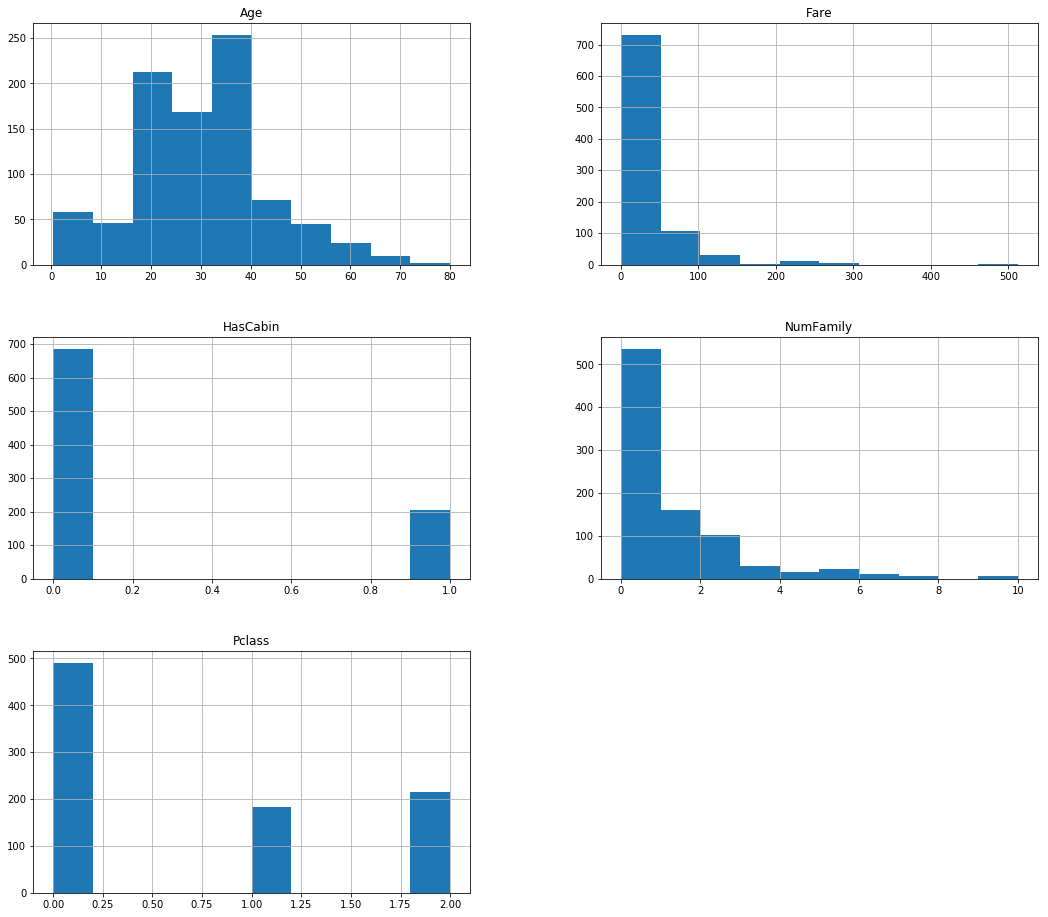

In [3]:
if PLOT:
    train.hist(figsize=(18, 16))

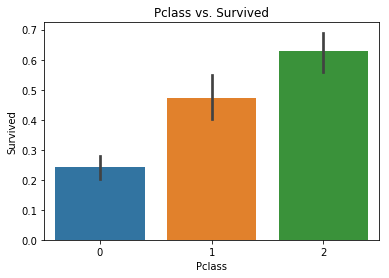

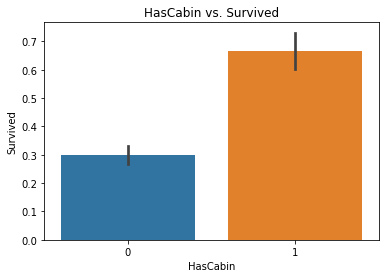

In [4]:
if PLOT:   
    for label in CORRELATED_LABELS:
        sns.barplot(x=label, y="Survived", data=dataframe)
        plt.xlabel(label)
        plt.ylabel("Survived")
        plt.title("{} vs. Survived".format(label))
        plt.show()

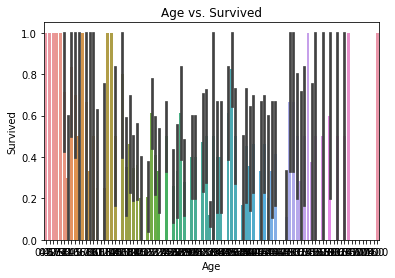

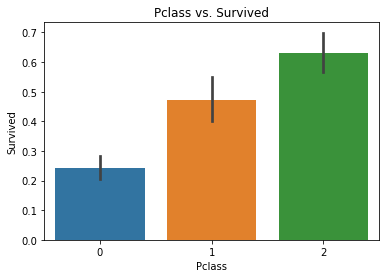

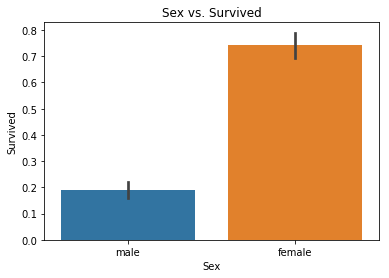

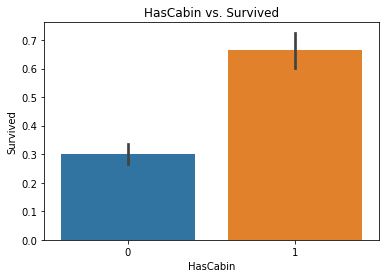

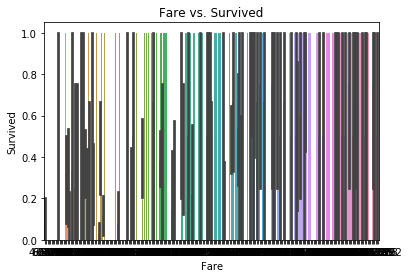

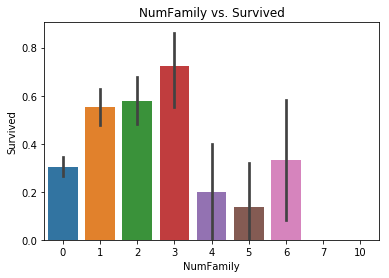

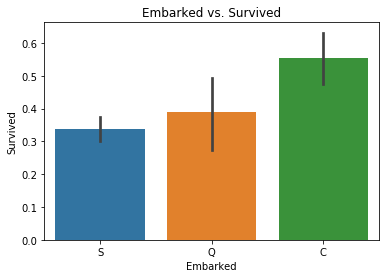

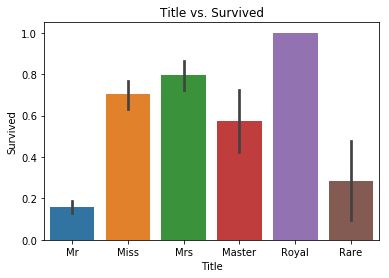

In [5]:
if PLOT:
    for label in FEATURES:
        sns.barplot(x=label, y=target_label, data=dataframe)
        plt.xlabel(label)
        plt.ylabel(target_label)
        plt.title("{} vs. {}".format(label, target_label)),
        p = dataframe[[label, target_label]].groupby([label], as_index=False).mean()
        plt.show()

In [6]:
# Split dataset 80/20 for training and validation
target = pd.DataFrame()
target[target_label] = dataframe[target_label]
df_size = dataframe.shape[0]
t_size = round(0.8 * df_size)
v_size = df_size - t_size

training_examples = train.head(t_size)
training_targets = target.head(t_size)
validation_examples = train.tail(v_size)
validation_targets = target.tail(v_size)

# x_train, y_train = train.head(t_size), target.head(t_size)
# x_val, y_val = train.tail(v_size), target.tail(v_size)
# num_features = train.shape[1] - 1
# randomforest = RandomForestClassifier()
# randomforest.fit(x_train, y_train)
# y_pred = randomforest.predict(x_val)
# acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
# print(acc_randomforest)

In [7]:
print("Training Examples:")
summarize(training_examples)
print("Training Targets:")
summarize(training_targets)

Training Examples:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 163 to 24
Data columns (total 8 columns):
Embarked     713 non-null object
Fare         713 non-null float64
HasCabin     713 non-null int64
Title        713 non-null object
Sex          713 non-null object
Age          713 non-null float64
Pclass       713 non-null int64
NumFamily    713 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 50.1+ KB
None


,Fare,HasCabin,Age,Pclass,NumFamily
count,713.0,713.0,713.0,713.0,713.0
mean,32.6,0.2,29.7,0.7,0.9
std,52.3,0.4,13.4,0.8,1.7
min,0.0,0.0,0.4,0.0,0.0
25%,7.9,0.0,21.8,0.0,0.0
50%,14.5,0.0,30.0,0.0,0.0
75%,30.7,0.0,35.8,1.0,1.0
max,512.3,1.0,80.0,2.0,10.0


Training Targets:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 713 entries, 163 to 24
Data columns (total 1 columns):
Survived    713 non-null int64
dtypes: int64(1)
memory usage: 11.1 KB
None


,Survived
count,713.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


In [8]:
print("Validation Examples:")
summarize(validation_examples)
print("Validation Targets:")
summarize(validation_targets)

Validation Examples:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 470 to 415
Data columns (total 8 columns):
Embarked     178 non-null object
Fare         178 non-null float64
HasCabin     178 non-null int64
Title        178 non-null object
Sex          178 non-null object
Age          178 non-null float64
Pclass       178 non-null int64
NumFamily    178 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 12.5+ KB
None


,Fare,HasCabin,Age,Pclass,NumFamily
count,178.0,178.0,178.0,178.0,178.0
mean,30.6,0.3,30.1,0.8,0.9
std,37.3,0.4,12.8,0.8,1.5
min,0.0,0.0,0.8,0.0,0.0
25%,8.1,0.0,22.0,0.0,0.0
50%,15.4,0.0,32.2,1.0,0.0
75%,33.9,1.0,35.9,2.0,1.0
max,263.0,1.0,64.0,2.0,10.0


Validation Targets:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 178 entries, 470 to 415
Data columns (total 1 columns):
Survived    178 non-null int64
dtypes: int64(1)
memory usage: 2.8 KB
None


,Survived
count,178.0
mean,0.4
std,0.5
min,0.0
25%,0.0
50%,0.0
75%,1.0
max,1.0


[27, 9, 6]
Training model...
	Accuracy:
		Period: 0	Test: 0.84	Validation: 0.79
		Period: 1	Test: 0.85	Validation: 0.79
		Period: 2	Test: 0.86	Validation: 0.79
		Period: 3	Test: 0.86	Validation: 0.80
		Period: 4	Test: 0.86	Validation: 0.80
		Period: 5	Test: 0.87	Validation: 0.80
		Period: 6	Test: 0.87	Validation: 0.80
		Period: 7	Test: 0.87	Validation: 0.80
		Period: 8	Test: 0.87	Validation: 0.80
		Period: 9	Test: 0.88	Validation: 0.80
Model training finished.


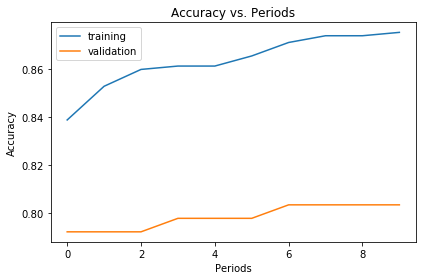

Final accuracy (on validation data): 0.80


In [9]:
layers = 3
units = [math.ceil(t_size ** (1/i)) for i in range(2, 2+layers)]
#units = [26, 9, 5]
print(units)
classifier, accuracy = train_nn_classification_model(
    learning_rate=0.0025,
    steps=100000,
    hidden_units=units,
    batch_size=25,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    l1=True,
    l1_strength=0.001)
accuracy *= 100

In [10]:
test_data = pd.read_csv(paths["Testing"], sep=",")
test_target = pd.Series(np.zeros(test_data.shape[0], dtype=int))
ids = test_data.pop(id_label)

# Prepare and sanitize test data
test_data = preprocess_features(preprocess_all_data(test_data, merge=False))
safe_labels = set(list(FEATURES) + list(CORRELATED_LABELS))
for label in test_data.columns:
    if label not in safe_labels:
        test_data.drop(label, axis=1)
for label in safe_labels:
    if label not in test_data.columns:
        test_data[label] = pd.Series(np.zeros(ids.shape[0]))
        
summarize(test_data) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Embarked     418 non-null object
Fare         418 non-null float64
HasCabin     418 non-null int64
Title        418 non-null object
Sex          418 non-null object
Age          418 non-null float64
Pclass       418 non-null int64
NumFamily    418 non-null int64
dtypes: float64(2), int64(3), object(3)
memory usage: 26.2+ KB
None


,Fare,HasCabin,Age,Pclass,NumFamily
count,418.0,418.0,418.0,418.0,418.0
mean,35.6,0.2,30.2,0.7,0.8
std,55.9,0.4,13.0,0.8,1.5
min,0.0,0.0,0.2,0.0,0.0
25%,7.9,0.0,21.8,0.0,0.0
50%,14.5,0.0,30.0,0.0,0.0
75%,31.5,0.0,36.9,2.0,1.0
max,512.3,1.0,76.0,2.0,10.0


In [11]:
#predictions = randomforest.predict(test_data)
# output = pd.DataFrame({id_label:ids, target_label:predictions }, dtype=np.int32)
# accuracy = round(accuracy_score(y_pred, y_val) * 100, 2)
# print("Accuracy: {:.2f}".format(accuracy))
# combined = test_data.copy()
# combined[target_label] = predictions


fn = lambda: my_input_fn(test_data, test_target, num_epochs=1, shuffle=False)
predictions = np.array([item['class_ids'][0] for item in classifier.predict(input_fn=fn)])
output = pd.DataFrame({id_label:ids, target_label:predictions }, dtype=np.int32)
name = OUTSTR.format(accuracy, CORR_THRESH, TYPE, ''.join([s[:2] for s in FEATURES]), "_" + NOTES if NOTES else "")
print("Outputting to: '{}'".format(name))
output.to_csv(name, index=False)

Outputting to: 'A80.34_C0.30_TypeDNN_FAgPcSeHaFaNuEmTi.csv'
